# Deep Q-Learning 

Install dependencies for AI gym to run properly (shouldn't take more than a minute). If running on google cloud or running locally, only need to run once. Colab may require installing everytime the vm shuts down.

In [10]:
!pip3 install gym pyvirtualdisplay
!sudo apt-get install -y xvfb python-opengl ffmpeg

[sudo] password for wxzhang: 


In [11]:
!pip3 install --upgrade setuptools --user
!pip3 install ez_setup 
!pip3 install gym[atari] 
!pip3 install gym[accept-rom-license] 

For this assignment we will implement the Deep Q-Learning algorithm with Experience Replay as described in breakthrough paper __"Playing Atari with Deep Reinforcement Learning"__. We will train an agent to play the famous game of __Breakout__.

In [1]:
%matplotlib inline

import sys
import gym
import torch
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from utils import find_max_lives, check_live, get_frame, get_init_state
from model import DQN, DQN_LSTM
from config import *

import matplotlib.pyplot as plt
# %load_ext autoreload
# %autoreload 2

## Understanding the environment

In the following cell, we initialize our game of __Breakout__ and you can see how the environment looks like. For further documentation of the of the environment refer to https://gym.openai.com/envs. 

In breakout, we will use 3 actions "fire", "left", and "right". "fire" is only used to reset the game when a life is lost, "left" moves the agent left and "right" moves the agent right.

In [2]:
env = gym.make('BreakoutDeterministic-v4')
state = env.reset()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [3]:
number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 3 #fire, left, and right

/home/wxzhang/anaconda3/envs/cv/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## Creating a DQN Agent

Here we create a DQN Agent. This agent is defined in the __agent.py__. The corresponding neural network is defined in the __model.py__. Once you've created a working DQN agent, use the code in agent.py to create a double DQN agent in __agent_double.py__. Set the flag "double_dqn" to True to train the double DQN agent.

__Evaluation Reward__ : The average reward received in the past 100 episodes/games.

__Frame__ : Number of frames processed in total.

__Memory Size__ : The current size of the replay memory.

In [4]:
double_dqn = True # set to True if using double DQN agent

if double_dqn:
    from agent_double import Agent
else:
    from agent import Agent

agent = Agent(action_size)
evaluation_reward = deque(maxlen=evaluation_reward_length)
frame = 0
memory_size = 0

### Main Training Loop

In this training loop, we do not render the screen because it slows down training signficantly. To watch the agent play the game, run the code in next section "Visualize Agent Performance"

episode: 0   score: 0.0   memory length: 123   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 0.0
episode: 1   score: 2.0   memory length: 320   epsilon: 1.0    steps: 197    lr: 0.0001     evaluation reward: 1.0
episode: 2   score: 3.0   memory length: 545   epsilon: 1.0    steps: 225    lr: 0.0001     evaluation reward: 1.6666666666666667
episode: 3   score: 6.0   memory length: 910   epsilon: 1.0    steps: 365    lr: 0.0001     evaluation reward: 2.75
episode: 4   score: 0.0   memory length: 1032   epsilon: 1.0    steps: 122    lr: 0.0001     evaluation reward: 2.2
episode: 5   score: 1.0   memory length: 1202   epsilon: 1.0    steps: 170    lr: 0.0001     evaluation reward: 2.0
episode: 6   score: 0.0   memory length: 1325   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 1.7142857142857142
episode: 7   score: 1.0   memory length: 1493   epsilon: 1.0    steps: 168    lr: 0.0001     evaluation reward: 1.625
episode: 8   score: 1.0   memory length: 16

/home/wxzhang/assignment5/memory.py:30: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sample = np.array(sample, dtype=object)
/home/wxzhang/assignment5/agent.py:67: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(co

episode: 536   score: 0.0   memory length: 100096   epsilon: 0.9998079400000042    steps: 123    lr: 0.0001     evaluation reward: 1.48
episode: 537   score: 2.0   memory length: 100316   epsilon: 0.9993723400000136    steps: 220    lr: 0.0001     evaluation reward: 1.5
episode: 538   score: 2.0   memory length: 100533   epsilon: 0.998942680000023    steps: 217    lr: 0.0001     evaluation reward: 1.52
episode: 539   score: 1.0   memory length: 100702   epsilon: 0.9986080600000302    steps: 169    lr: 0.0001     evaluation reward: 1.51
episode: 540   score: 0.0   memory length: 100825   epsilon: 0.9983645200000355    steps: 123    lr: 0.0001     evaluation reward: 1.51
episode: 541   score: 1.0   memory length: 100975   epsilon: 0.998067520000042    steps: 150    lr: 0.0001     evaluation reward: 1.5
episode: 542   score: 2.0   memory length: 101173   epsilon: 0.9976754800000505    steps: 198    lr: 0.0001     evaluation reward: 1.51
episode: 543   score: 1.0   memory length: 101343   

KeyboardInterrupt: 

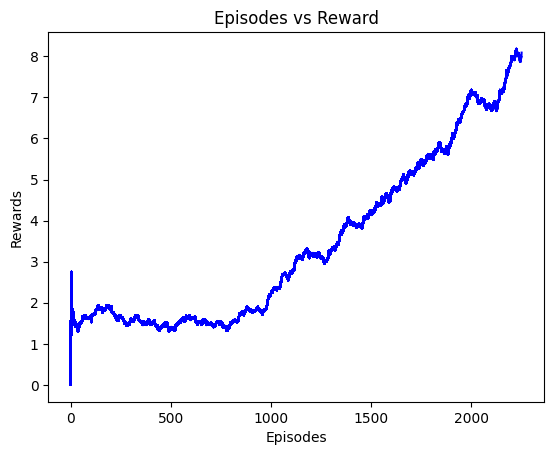

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

rewards, episodes = [], []
best_eval_reward = 0
for e in range(EPISODES):
    done = False
    score = 0

    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    state, _ = env.reset()
    next_state = state
    life = number_lives

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        step += 1
        frame += 1

        # Perform a fire action if ball is no longer on screen to continue onto next life
        if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
            action = torch.tensor([[0]]).cuda()
        else:
            action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        state = next_state
        next_state, reward, terminated, truncated, info = env.step(action + 1)
        done = terminated or truncated
        
        frame_next_state = get_frame(next_state)
        history[4, :, :] = frame_next_state
        terminal_state = check_live(life, info['lives'])

        life = info['lives']
        r = reward

        # Store the transition in memory 
        agent.memory.push(deepcopy(frame_next_state), action.cpu(), r, terminal_state)
        # Start training after random sample generation
        if(frame >= train_frame): # You can set train_frame to a lower value while testing your starts training earlier
            agent.train_policy_net(frame)
            # Update the target network only for Double DQN only
            if double_dqn and (frame % update_target_network_frequency)== 0:
                agent.update_target_net()
        score += reward
        history[:4, :, :] = history[1:, :, :]
            
        if done:
            evaluation_reward.append(score)
            rewards.append(np.mean(evaluation_reward))
            episodes.append(e)
            pylab.plot(episodes, rewards, 'b')
            pylab.xlabel('Episodes')
            pylab.ylabel('Rewards') 
            pylab.title('Episodes vs Reward')
            pylab.savefig("./save_graph/breakout_dqn.png") # save graph for training visualization
            
            # every episode, plot the play time
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon, "   steps:", step,
                  "   lr:", agent.optimizer.param_groups[0]['lr'], "    evaluation reward:", np.mean(evaluation_reward))

            # if the mean of scores of last 100 episode is bigger than 5 save model
            ### Change this save condition to whatever you prefer ###
            if np.mean(evaluation_reward) > 6 and np.mean(evaluation_reward) > best_eval_reward:
                save_dir = "./save_model/breakout_dqn_"+str(e)+".pth"
                torch.save(agent.policy_net, save_dir)
                best_eval_reward = np.mean(evaluation_reward)


# Trianing a double DQN

episode: 0   score: 3.0   memory length: 249   epsilon: 1.0    steps: 249    lr: 0.0001     evaluation reward: 3.0
episode: 1   score: 3.0   memory length: 497   epsilon: 1.0    steps: 248    lr: 0.0001     evaluation reward: 3.0
episode: 2   score: 2.0   memory length: 694   epsilon: 1.0    steps: 197    lr: 0.0001     evaluation reward: 2.6666666666666665
episode: 3   score: 2.0   memory length: 891   epsilon: 1.0    steps: 197    lr: 0.0001     evaluation reward: 2.5
episode: 4   score: 3.0   memory length: 1138   epsilon: 1.0    steps: 247    lr: 0.0001     evaluation reward: 2.6
episode: 5   score: 0.0   memory length: 1260   epsilon: 1.0    steps: 122    lr: 0.0001     evaluation reward: 2.1666666666666665
episode: 6   score: 4.0   memory length: 1517   epsilon: 1.0    steps: 257    lr: 0.0001     evaluation reward: 2.4285714285714284
episode: 7   score: 1.0   memory length: 1685   epsilon: 1.0    steps: 168    lr: 0.0001     evaluation reward: 2.25
episode: 8   score: 0.0   memo

/home/wxzhang/assignment5/memory.py:30: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sample = np.array(sample, dtype=object)
/home/wxzhang/assignment5/agent_double.py:78: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.e

episode: 537   score: 1.0   memory length: 100108   epsilon: 0.9997841800000047    steps: 151    lr: 0.0001     evaluation reward: 1.54
episode: 538   score: 1.0   memory length: 100278   epsilon: 0.999447580000012    steps: 170    lr: 0.0001     evaluation reward: 1.53
episode: 539   score: 0.0   memory length: 100401   epsilon: 0.9992040400000173    steps: 123    lr: 0.0001     evaluation reward: 1.52
episode: 540   score: 3.0   memory length: 100631   epsilon: 0.9987486400000272    steps: 230    lr: 0.0001     evaluation reward: 1.53
episode: 541   score: 1.0   memory length: 100802   epsilon: 0.9984100600000345    steps: 171    lr: 0.0001     evaluation reward: 1.54
episode: 542   score: 1.0   memory length: 100952   epsilon: 0.998113060000041    steps: 150    lr: 0.0001     evaluation reward: 1.53
episode: 543   score: 1.0   memory length: 101103   epsilon: 0.9978140800000475    steps: 151    lr: 0.0001     evaluation reward: 1.53
episode: 544   score: 7.0   memory length: 101513 

KeyboardInterrupt: 

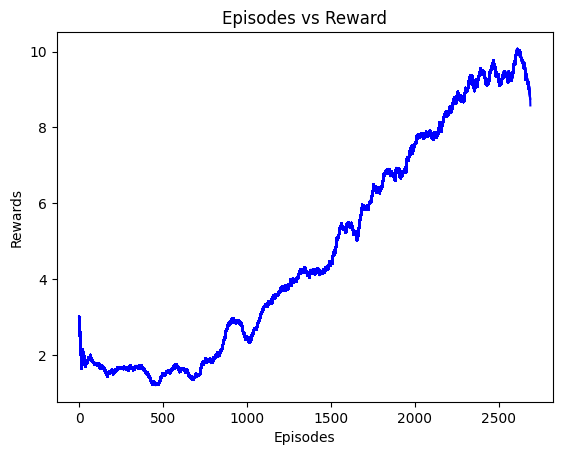

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

rewards, episodes = [], []
best_eval_reward = 0
for e in range(EPISODES):
    done = False
    score = 0

    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    state, _ = env.reset()
    next_state = state
    life = number_lives

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        step += 1
        frame += 1

        # Perform a fire action if ball is no longer on screen to continue onto next life
        if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
            action = torch.tensor([[0]]).cuda()
        else:
            action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        state = next_state
        next_state, reward, terminated, truncated, info = env.step(action + 1)
        done = terminated or truncated
        
        frame_next_state = get_frame(next_state)
        history[4, :, :] = frame_next_state
        terminal_state = check_live(life, info['lives'])

        life = info['lives']
        r = reward

        # Store the transition in memory 
        agent.memory.push(deepcopy(frame_next_state), action.cpu(), r, terminal_state)
        # Start training after random sample generation
        if(frame >= train_frame): # You can set train_frame to a lower value while testing your starts training earlier
            agent.train_policy_net(frame)
            # Update the target network only for Double DQN only
            if double_dqn and (frame % update_target_network_frequency)== 0:
                agent.update_target_net()
        score += reward
        history[:4, :, :] = history[1:, :, :]
            
        if done:
            evaluation_reward.append(score)
            rewards.append(np.mean(evaluation_reward))
            episodes.append(e)
            pylab.plot(episodes, rewards, 'b')
            pylab.xlabel('Episodes')
            pylab.ylabel('Rewards') 
            pylab.title('Episodes vs Reward')
            pylab.savefig("./save_graph/breakout_dqn.png") # save graph for training visualization
            
            # every episode, plot the play time
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon, "   steps:", step,
                  "   lr:", agent.optimizer.param_groups[0]['lr'], "    evaluation reward:", np.mean(evaluation_reward))

            # if the mean of scores of last 100 episode is bigger than 5 save model
            ### Change this save condition to whatever you prefer ###
            if np.mean(evaluation_reward) > 6 and np.mean(evaluation_reward) > best_eval_reward:
                save_dir = "./save_model/breakout_ddqn_"+str(e)+".pth"
                torch.save(agent.policy_net, save_dir)
                best_eval_reward = np.mean(evaluation_reward)


# Visualize Agent Performance

BE AWARE THIS CODE BELOW MAY CRASH THE KERNEL IF YOU RUN THE SAME CELL TWICE.

Please save your model before running this portion of the code.

In [6]:
torch.save(agent.policy_net, "./save_model/breakout_dqn_2226.pth")

In [7]:
import sys
import gym
import torch
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
from utils import find_max_lives, check_live, get_frame, get_init_state
from model import DQN, DQN_LSTM
from config import *

import matplotlib.pyplot as plt
# %load_ext autoreload
# %autoreload 2

from gym.wrappers import RecordVideo # If importing monitor raises issues, try using `from gym.wrappers import RecordVideo`
import glob
import io
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display


env = gym.make('BreakoutDeterministic-v4', render_mode='rgb_array')
state = env.reset()
number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 3 #fire, left, and right

# Displaying the game live
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % ("Agent Playing",step, info))
    plt.axis('off')

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    
# Recording the game and replaying the game afterwards
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = RecordVideo(env, './video')
    return env

from agent import Agent
action_size = 3 

display = Display(visible=0, size=(300, 200))
display.start()

# Load agent
agent = Agent(action_size)
agent.load_policy_net("./save_model/breakout_dqn_2226.pth")
agent.epsilon = 0.0 # Set agent to only exploit the best action

env = wrap_env(env)

done = False
score = 0
step = 0
state, _ = env.reset()
next_state = state
life = number_lives
history = np.zeros([5, 84, 84], dtype=np.uint8)
get_init_state(history, state, HISTORY_SIZE)
frame = 0
while not done:
#     show_state(env,step) # uncommenting this provides another way to visualize the game
    step += 1
    frame += 1

    # Perform a fire action if ball is no longer on screen
    if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
        action = 0
    else:
        action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
    state = next_state
    
    next_state, reward, done, _, info = env.step(action + 1)
        
    frame_next_state = get_frame(next_state)
    history[4, :, :] = frame_next_state
    terminal_state = check_live(life, info['lives'])
        
    life = info['lives']
    r = np.clip(reward, -1, 1) 
    r = reward

    # Store the transition in memory 
    agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
    # Start training after random sample generation
    score += reward
    
    history[:4, :, :] = history[1:, :, :]
env.close()
show_video()
display.stop()

/home/wxzhang/anaconda3/envs/cv/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


/home/wxzhang/anaconda3/envs/cv/lib/python3.8/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /home/wxzhang/assignment5/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/home/wxzhang/anaconda3/envs/cv/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Moviepy - Building video /home/wxzhang/assignment5/video/rl-video-episode-0.mp4.
Moviepy - Writing video /home/wxzhang/assignment5/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/wxzhang/assignment5/video/rl-video-episode-0.mp4


# video for double DQN

In [5]:
torch.save(agent.policy_net, "./save_model/breakout_ddqn_2612.pth")
import sys
import gym
import torch
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
from utils import find_max_lives, check_live, get_frame, get_init_state
from model import DQN, DQN_LSTM
from config import *

import matplotlib.pyplot as plt
# %load_ext autoreload
# %autoreload 2

from gym.wrappers import RecordVideo # If importing monitor raises issues, try using `from gym.wrappers import RecordVideo`
import glob
import io
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display


env = gym.make('BreakoutDeterministic-v4', render_mode='rgb_array')
state = env.reset()
number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 3 #fire, left, and right

# Displaying the game live
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % ("Agent Playing",step, info))
    plt.axis('off')

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    
# Recording the game and replaying the game afterwards
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = RecordVideo(env, './video')
    return env

from agent import Agent
action_size = 3 

display = Display(visible=0, size=(300, 200))
display.start()

# Load agent
agent = Agent(action_size)
agent.load_policy_net("./save_model/breakout_dqn_2226.pth")
agent.epsilon = 0.0 # Set agent to only exploit the best action

env = wrap_env(env)

done = False
score = 0
step = 0
state, _ = env.reset()
next_state = state
life = number_lives
history = np.zeros([5, 84, 84], dtype=np.uint8)
get_init_state(history, state, HISTORY_SIZE)
frame = 0
while not done:
#     show_state(env,step) # uncommenting this provides another way to visualize the game
    step += 1
    frame += 1

    # Perform a fire action if ball is no longer on screen
    if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
        action = 0
    else:
        action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
    state = next_state
    
    next_state, reward, done, _, info = env.step(action + 1)
        
    frame_next_state = get_frame(next_state)
    history[4, :, :] = frame_next_state
    terminal_state = check_live(life, info['lives'])
        
    life = info['lives']
    r = np.clip(reward, -1, 1) 
    r = reward

    # Store the transition in memory 
    agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
    # Start training after random sample generation
    score += reward
    
    history[:4, :, :] = history[1:, :, :]
env.close()
show_video()
display.stop()


/home/wxzhang/anaconda3/envs/cv/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/wxzhang/anaconda3/envs/cv/lib/python3.8/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /home/wxzhang/assignment5/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/home/wxzhang/anaconda3/envs/cv/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Moviepy - Building video /home/wxzhang/assignment5/video/rl-video-episode-0.mp4.
Moviepy - Writing video /home/wxzhang/assignment5/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/wxzhang/assignment5/video/rl-video-episode-0.mp4
